# KNN Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, mean_squared_error


In [2]:
data = pd.read_csv('../data/data_processed.csv')

data['target'] = data['readmitted'].isin(['<30','>30']).astype(int)

data = data.drop(columns='readmitted')

In [3]:
X = data.drop(columns = 'target')
y = data['target']

X['strat_col'] = X['race'].astype(str) + "_" + data['target'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train = X_train.drop(columns = ['strat_col' , 'race'])
X_test = X_test.drop(columns = ['strat_col' , 'race'])

We begin by using a grid search to try and tune the knn classifier. We try to understand how changing the number of neighbors considered by the classifier effects the auc score.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [5]:
pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])

gsearch = GridSearchCV(estimator=pipe,
                       param_grid={'knn__n_neighbors': [5,9,13,15,19]},
                       scoring = 'roc_auc',
                       cv = 5)

gsearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 9, 13, 15, 19]},
             scoring='roc_auc')

In [6]:
print('Best AUC score: ', gsearch.best_score_)
print('Best parameters: ', gsearch.best_params_)

Best AUC score:  0.7454856459649355
Best parameters:  {'knn__n_neighbors': 19}


In [7]:
gsearch.cv_results_

{'mean_fit_time': array([0.08415895, 0.08656716, 0.0870049 , 0.08582582, 0.08621526]),
 'std_fit_time': array([0.00243385, 0.00282696, 0.00441036, 0.00270527, 0.00417048]),
 'mean_score_time': array([0.9406354 , 0.68362803, 0.68334165, 0.67532349, 0.67096548]),
 'std_score_time': array([0.51095333, 0.02497077, 0.00962331, 0.0099962 , 0.0109376 ]),
 'param_knn__n_neighbors': masked_array(data=[5, 9, 13, 15, 19],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'params': [{'knn__n_neighbors': 5},
  {'knn__n_neighbors': 9},
  {'knn__n_neighbors': 13},
  {'knn__n_neighbors': 15},
  {'knn__n_neighbors': 19}],
 'split0_test_score': array([0.70047911, 0.72227563, 0.73066861, 0.7351554 , 0.74145889]),
 'split1_test_score': array([0.70318769, 0.72736546, 0.73860693, 0.74374287, 0.74904474]),
 'split2_test_score': array([0.69520914, 0.72029035, 0.73189541, 0.73539968, 0.74212924]),
 'split3_test_score': array([0.69908567, 0.72385498, 0.73632963, 0.74102945, 0.

As one can observe, while increasing the number of neighbors seems to marginally improve the auc, the score is still pretty bad. It can be shown that xgboost, for example, with default parameters will beat this. This shows knn is the wrong classifier for our problem. For the sake of completness we still run the classifier on the test data with the optimal parameter values found by the grid search.

<function matplotlib.pyplot.show(close=None, block=None)>

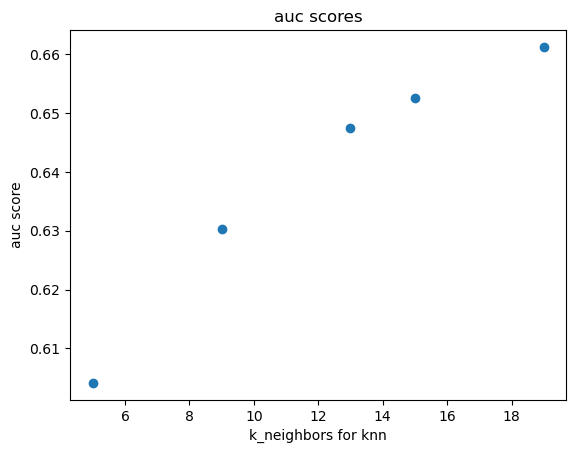

In [8]:
k_nbs = np.array([5,9,13,15,19])
mean_auc_score = np.array([0.6041603 , 0.63020854, 0.64735655, 0.65260077, 0.66122804])

plt.scatter(k_nbs, mean_auc_score)
plt.title('auc scores')
plt.xlabel('k_neighbors for knn')
plt.ylabel('auc score')
plt.show


**Final Fit and Evaluation**

In [9]:
pipe_tuned = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(19))])
pipe_tuned.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=19))])

In [10]:
y_pred = pipe_tuned.predict(X_train)

In [11]:
probs = pipe_tuned.predict_proba(X_test)
y_pred = (probs[:, 1]>=0.5)

In [12]:
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probs[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

In [13]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)
print("ROC AUC score = ",roc_auc)

Confusion Matrix:
[[8735 1469]
 [4699 4519]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.86      0.74     10204
           1       0.75      0.49      0.59      9218

    accuracy                           0.68     19422
   macro avg       0.70      0.67      0.67     19422
weighted avg       0.70      0.68      0.67     19422

Mean squared error =  0.3175780043249923
Accuracy =  0.6824219956750077
ROC AUC score =  0.7456383697500475


In [14]:
roc_data = pd.DataFrame({'X': false_pos_rate.tolist(), 'Y': true_pos_rate.tolist()})
roc_data.to_csv('./figs/plot_data/bal_roc_curve_kNN.csv', index=False)

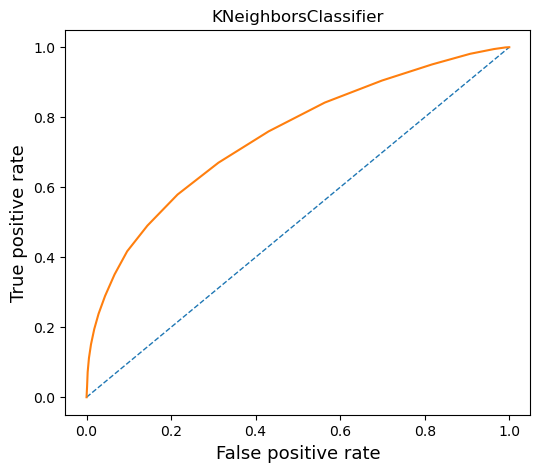

In [15]:
plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], '--', lw=1)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('KNeighborsClassifier')
plt.show()

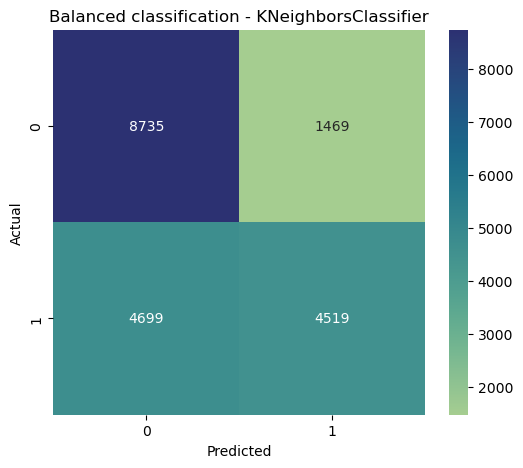

Confusion Matrix:
 [[8735 1469]
 [4699 4519]]


In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Balanced classification - KNeighborsClassifier')

plt.savefig('./figs/bal_conf_mat_knn.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)